In [ ]:
import torch
import torchaudio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from call_of_func.train.train_helper import get_device
from call_of_birds_autobird.model import Model

from matplotlib import colormaps
data_root = Path.cwd().parent / "data" 
print(f"Data path:{data_root}")
train_x = torch.load(data_root / "processed" / "train_x.pt")

print(train_x[0, 0].shape)

print(list(colormaps))
plt.figure(figsize=(12, 6))
plt.imshow(train_x[12, 0].numpy(), cmap='magma')
plt.title('Sample from train_x')
plt.colorbar()
plt.tight_layout()
plt.show()

print(f"Shape: {train_x.shape}")
print(f"Data type: {train_x.dtype}")
print(f"Min: {train_x.min()}, Max: {train_x.max()}")

In [ ]:
def plot_waveform_and_mel(waveform: torch.Tensor, mel: torch.Tensor, sr: int):
    """
    waveform: [1, N] or [N]
    mel: [n_mels, T]
    """
    # if waveform larger than 1 dim
    if waveform.ndim == 2:
        waveform_1d = waveform.squeeze(0) # [N] 
    else:
        waveform_1d = waveform # [N]

    waveform_1d = waveform_1d.detach().cpu()

    mel_2d = mel.detach().cpu()
    if mel_2d.ndim == 3:
        mel_2d = mel_2d.squeeze(0) # [n_mels, T]
    mel_2d = mel_2d.numpy()

    t = np.arange(waveform_1d.numel()) / sr

    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

    axs[0].plot(t, waveform_1d.numpy())
    axs[0].set_title("Waveform")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlim(0, t[-1] if len(t) > 0 else 1)

    axs[1].imshow(mel_2d, aspect="auto", origin="lower", cmap="magma")
    axs[1].set_title("Mel spectrogram (log)")
    axs[1].set_xlabel("Frame")
    axs[1].set_ylabel("Mel bin")

    plt.tight_layout()
    plt.show()


In [ ]:

raw_data = data_root / "voice_of_birds" / "Andean_Guan_sound" / "Andean_Guan10.mp3"
waveform, sr = torchaudio.load(raw_data)

# mono
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)

mel = mel_transform(waveform)         # [1, 64, time]
mel = torch.log(mel + 1e-6)           # log-compress
mel = mel.squeeze(0)                  # [64, time]

plot_waveform_and_mel(waveform, mel, sr)

In [ ]:
def plot_label_distribution(y, title="Label distribution"):
    import matplotlib.pyplot as plt
    import torch

    counts = torch.bincount(y)
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(counts)), counts.numpy())
    plt.xlabel("Class index")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
train_y = data_root / "processed" / "train_y.pt"
train_y = torch.load(train_y)
plot_label_distribution(train_y)

In [ ]:
def plot_value_histogram(x, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))
    plt.hist(x.flatten().numpy(), bins=100)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_value_histogram(train_x, "data distribution")

In [ ]:
def plot_specaugment(original, augmented):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(original, aspect="auto", origin="lower", cmap="magma")
    axs[0].set_title("Original")

    axs[1].imshow(augmented, aspect="auto", origin="lower", cmap="magma")
    axs[1].set_title("After SpecAugment")

    plt.tight_layout()
    plt.show()


In [ ]:
import torch

ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(ds, batch_size=32, shuffle=True)

x, y = next(iter(train_loader))     # x: [B, 1, n_mels, time]

mel_orig = x[0, 0].cpu()            # [n_mels, time]
mel_aug  = mel_orig.clone()

# IMPORTANT: masking expects torch.Tensor
mel_aug = fq_mask(mel_aug)
mel_aug = time_mask(mel_aug)

plot_specaugment(mel_orig.numpy(), mel_aug.numpy())


In [ ]:
import time
import torch
import torch.nn as nn

# 1) Infer n_classes from one batch (safe)
x0, y0 = next(iter(train_loader))
n_classes = int(y0.max().item()) + 1

# 2) Build model correctly (adapt to your Model signature)
from call_of_birds_autobird.model import Model
model = Model(
    n_classes=n_classes,
    d_model=128,   # or your cfg value
    n_heads=4,
    n_layers=2,
)

device = torch.device("cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
it = iter(train_loader)

# warmup
for _ in range(10):
    x, y = next(it)
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad(set_to_none=True)
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

# timing
N = 100
t0 = time.time()
for _ in range(N):
    x, y = next(it)
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad(set_to_none=True)
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

dt = time.time() - t0
print("avg train step seconds:", dt / N)



In [ ]:
def plot_confusion_matrix(cm, class_names=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:

device = torch.device("cuda") 

device = get_device()
ds = TensorDataset(train_x, train_y)
val_loader = DataLoader(ds, batch_size=32, shuffle=True)

model = Model(n_classes=len(train_y))

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()



In [ ]:
cm = confusion_matrix(all_targets, all_preds)
plot_confusion_matrix(cm)

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Optional, Sequence, Union
import json

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, class_names: Optional[Sequence[str]] = None):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    if class_names is not None:
        n = len(class_names)
        plt.xticks(range(n), class_names, rotation=90)
        plt.yticks(range(n), class_names)

    plt.tight_layout()
    plt.show()


def _load_labels(labels_path: Union[str, Path]) -> Optional[list[str]]:
    """Supports either list JSON ["a","b"] or dict JSON {"0":"a","1":"b"}."""
    p = Path(labels_path)
    if not p.exists():
        return None
    with p.open() as f:
        obj = json.load(f)
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        return [obj[str(i)] for i in range(len(obj))]
    return None


def confusion_matrix_from_checkpoint(
    model_cls,
    ckpt_path: Union[str, Path],
    x: torch.Tensor,
    y: torch.Tensor,
    batch_size: int = 32,
    device: Optional[torch.device] = None,
    labels_path: Optional[Union[str, Path]] = None,
    strict: bool = True,
    normalize: Optional[str] = None,  # None | "true" | "pred" | "all"
    plot: bool = True,
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    ckpt_path = Path(ckpt_path)
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # Figure out checkpoint format + hp (if present)
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        state_dict = ckpt["model_state"]
        hp = ckpt.get("hp", {})  # might be dict / omegaconf container
    else:
        state_dict = ckpt
        hp = {}

    # Determine n_classes from labels if available (best), else from y
    class_names = _load_labels(labels_path) if labels_path is not None else None
    if class_names is not None:
        n_classes = len(class_names)
    else:
        n_classes = int(torch.max(y).item()) + 1

    # Build model (match training hyperparams if stored, else defaults)
    # If your Model signature is Model(n_classes, d_model, n_heads, n_layers)
    model = model_cls(
        n_classes=n_classes,
        d_model=int(hp.get("d_model", 64)) if isinstance(hp, dict) else 64,
        n_heads=int(hp.get("n_heads", 2)) if isinstance(hp, dict) else 2,
        n_layers=int(hp.get("n_layers", 1)) if isinstance(hp, dict) else 1,
    ).to(device)

    model.load_state_dict(state_dict, strict=strict)
    model.eval()

    # Loader
    ds = TensorDataset(x, y)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(n_classes)), normalize=normalize)

    if plot:
        plot_confusion_matrix(cm, class_names=class_names)

    return cm


/Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_3/project/mlops_project/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


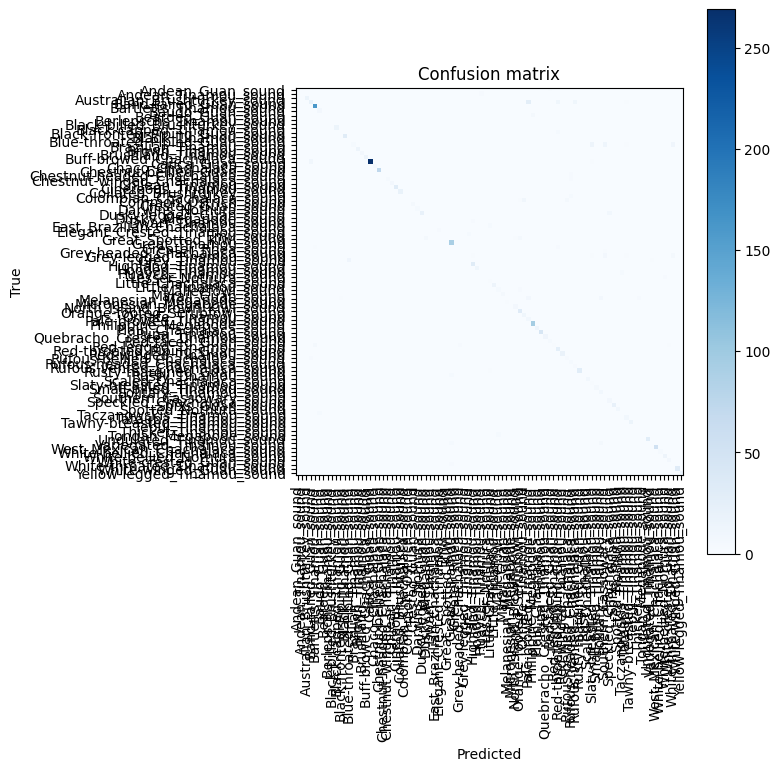

Confusion matrix shape: (91, 91)
Accuracy: 0.8024
Classes with highest errors: [49 26 39 13  3]
Classes with highest accuracy: [89  8 79  7 30]
Top accuracies: [ 1. nan nan nan nan]


/var/folders/m7/bb8y972s4gl6rtt12h15d9mw0000gn/T/ipykernel_99858/2035412391.py:35: RuntimeWarning: invalid value encountered in divide
  high_accuracy_classes = cm.diagonal() / cm.sum(axis=1)


In [4]:
from call_of_birds_autobird.model import Model
from call_of_func.train.train_helper import _get_device
from pathlib import Path
import torch
import numpy as np

local_rank = 0
device = _get_device(local_rank)

root = Path.cwd().parent

test_x = torch.load(root / "data" / "processed" / "test_x.pt")
test_y = torch.load(root / "data" / "processed" / "test_y.pt") 

cm = confusion_matrix_from_checkpoint(
    model_cls=Model,
    ckpt_path=root / "models" / "checkpoints" / "best.pt",
    x=test_x,
    y=test_y,
    batch_size=32,
    device=device,
    labels_path=root / "data" / "processed" / "labels.json",
    strict=True,
    normalize=None,   # try "true" for row-normalized
    plot=True,
)
print(f"Confusion matrix shape: {cm.shape}")
accuracy = cm.trace() / cm.sum()
print(f"Accuracy: {accuracy:.4f}")

high_error_classes = cm.sum(axis=1) - cm.diagonal()
top_error_idx = high_error_classes.argsort()[-5:]
print(f"Classes with highest errors: {top_error_idx}")

high_accuracy_classes = cm.diagonal() / cm.sum(axis=1)
top_accuracy_idx = np.argsort(high_accuracy_classes)[-5:]
print(f"Classes with highest accuracy: {top_accuracy_idx}")
print(f"Top accuracies: {high_accuracy_classes[top_accuracy_idx]}")